<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Capstone Project - The Battle of Neighborhoods</font></h1>


## Introduction

New York City (NYC) is one of the most energy-intensive urban environments in the world. The peak summer load of NYC approaches 14 GW of demand — almost a quarter of the peak demand in all of California. In addition, while nearly 60 percent of the state’s electricity is consumed in the NYC, only 40 percent of it is generated there. This urban grid delivers energy primarily through an underground network, which makes managing and maintaining the system an expensive and challenging endeavor to continue to meet the rapidly growing peak load. As part of the solution—and as an alternative to building out traditional grid infrastructure, New York is looking at local generation and storage options to cover peak load, optimize delivery systems, and make the grid more efficient and reliable.

The availability of reliable, resilient, and affordable electric service is critical to the welfare of NYC citizens and is central to New York’s economy. To ensure continuing economic growth and prosperity for New York, the state laid out an ambitious energy agenda.  Through “Reforming the Energy Vision” (REV) strategy, New York is actively spurring clean energy innovation, bringing new investments into the State and improving consumer choice and affordability. Regulatory changes under the REV initiative are promoting more efficient use of energy, deeper penetration of renewable energy resources such as wind and solar, wider deployment of “distributed” energy resources, such as micro grids, roof-top solar and other on-site power supplies, and storage. It is also promoting markets to achieve greater use of advanced energy management products to enhance demand elasticity and efficiencies. These changes, in turn, will empower customers by allowing them more choice in how they manage and consume electric energy.

This transition to cleaner, more reliable and distributed energy resources presents great opportunities for energy efficiency service probivers, and solar and battery storage companies to tranform the electric grid of NY. So as part of this project , we will list and visualize all major parts of New York City that has large electric loads that are favorable targets to the energy service companies. 

## Data

For this project we need the following data :

- New York City data that contains list of Boroughs, Neighborhoods along with their latitude and longitude.
    - Data source : https://cocl.us/new_york_dataset
    - Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.

- Large electric loads in each neighborhood of new york city.
    - Data source : Fousquare API
    - Description : By using this api we will get all the venues in each neighborhood. We will filter these to get information for schools, universities, hospitals, super markets, and outlet malls etc.  

- GeoSpace data
    - Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
    - Description : By using this data we will get the New york Borough boundaries that will help us in visualizing choropleth map.

### How the data will be used?

- Collect the new york city data from https://cocl.us/new_york_dataset
- Use FourSquare API to find all venues for each neighborhood
- Filter out all large electric loads
- Find rating , tips and like count for large loads using FourSquare API. This information is used as a proxy for the profitability and finanical strength of these entities
- Sort the data based on rating
- Visualize the Ranking of neighborhoods using folium library(python)

### What all we will get?

- Areas that are favorable targets for energy service companies
- Equipped with this information, the energy service companies will be able to tailor and develop efficient sales and marketing strategies 

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
#import folium
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors

     |████████████████████████████████| 98 kB 9.1 MB/s  eta 0:00:01


In [2]:
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
def get_venues(lat,lng):
    
    radius=1000
    LIMIT=100
    CLIENT_ID = 'KLUB5M0KYOA3VGX5ESIUPKGMUMLICGN5LMDDIGKLYGRQLHC1' # your Foursquare ID
    CLIENT_SECRET = 'FWWEJIYJWWUF15GDYH0A0EJXRZGMJL3K0WT51TA0WHY4TZU1' # your Foursquare Secret
    VERSION = '20201208' 
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    if 'groups' not in results["response"]:
        return pd.DataFrame()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [4]:
def get_venue_details(venue_id):
    CLIENT_ID = 'KLUB5M0KYOA3VGX5ESIUPKGMUMLICGN5LMDDIGKLYGRQLHC1' # your Foursquare ID
    CLIENT_SECRET = 'FWWEJIYJWWUF15GDYH0A0EJXRZGMJL3K0WT51TA0WHY4TZU1' # your Foursquare Secret
    VERSION = '20201208'
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json()
    print(results['response'].keys())
    if 'venue' not in results['response'].keys():
        return pd.DataFrame()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
new_york_data=get_new_york_data()

In [7]:
new_york_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [8]:
new_york_data.shape

(306, 4)

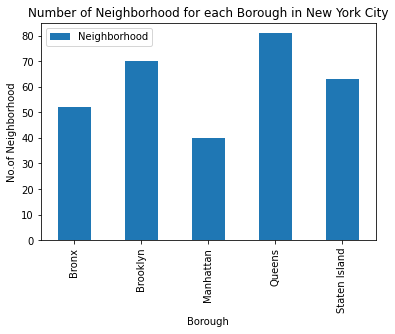

In [9]:
plt.title('Number of Neighborhood for each Borough in New York City')
plt.xlabel('Borough')
plt.ylabel('No.of Neighborhood')
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

In [10]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
electric_loads_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude) 
    if venues.empty==False:
        #electric_loads=venues[venues['Category']=='School']   
        electric_loads = venues[(venues.Category == 'Shop & Service') | (venues.Category == 'School') | (venues.Category == 'Hospital')]
        print('(',count,'/',len(new_york_data),')','Large electric loads '+Neighborhood+', '+Borough+':'+str(len(electric_loads)))
        for load_detail in electric_loads.values.tolist():
            id, name , category=load_detail
            electric_loads_ny = electric_loads_ny.append({'Borough': Borough,
                                                    'Neighborhood': Neighborhood, 
                                                    'ID': id,
                                                    'Name' : name
                                                }, ignore_index=True)
        count+=1

( 1 / 306 ) MUSH in Wakefield, Bronx:0
( 2 / 306 ) MUSH in Co-op City, Bronx:0
( 3 / 306 ) MUSH in Eastchester, Bronx:0
( 4 / 306 ) MUSH in Fieldston, Bronx:0
( 5 / 306 ) MUSH in Riverdale, Bronx:0
( 6 / 306 ) MUSH in Kingsbridge, Bronx:0
( 7 / 306 ) MUSH in Marble Hill, Manhattan:0
( 8 / 306 ) MUSH in Woodlawn, Bronx:0
( 9 / 306 ) MUSH in Norwood, Bronx:0
( 10 / 306 ) MUSH in Williamsbridge, Bronx:0
( 11 / 306 ) MUSH in Baychester, Bronx:0
( 12 / 306 ) MUSH in Pelham Parkway, Bronx:0
( 13 / 306 ) MUSH in City Island, Bronx:0
( 14 / 306 ) MUSH in Bedford Park, Bronx:0
( 15 / 306 ) MUSH in University Heights, Bronx:0
( 16 / 306 ) MUSH in Morris Heights, Bronx:0
( 17 / 306 ) MUSH in Fordham, Bronx:0
( 18 / 306 ) MUSH in East Tremont, Bronx:0
( 19 / 306 ) MUSH in West Farms, Bronx:0
( 20 / 306 ) MUSH in High  Bridge, Bronx:0
( 21 / 306 ) MUSH in Melrose, Bronx:0
( 22 / 306 ) MUSH in Mott Haven, Bronx:0
( 23 / 306 ) MUSH in Port Morris, Bronx:1
( 24 / 306 ) MUSH in Longwood, Bronx:0
( 25 /

( 185 / 306 ) MUSH in Hillcrest, Queens:0
( 186 / 306 ) MUSH in Ravenswood, Queens:0
( 187 / 306 ) MUSH in Lindenwood, Queens:0
( 188 / 306 ) MUSH in Laurelton, Queens:0
( 189 / 306 ) MUSH in Lefrak City, Queens:0
( 190 / 306 ) MUSH in Belle Harbor, Queens:0
( 191 / 306 ) MUSH in Rockaway Park, Queens:0
( 192 / 306 ) MUSH in Somerville, Queens:0
( 193 / 306 ) MUSH in Brookville, Queens:0
( 194 / 306 ) MUSH in Bellaire, Queens:0
( 195 / 306 ) MUSH in North Corona, Queens:1
( 196 / 306 ) MUSH in Forest Hills Gardens, Queens:0
( 197 / 306 ) MUSH in St. George, Staten Island:0
( 198 / 306 ) MUSH in New Brighton, Staten Island:0
( 199 / 306 ) MUSH in Stapleton, Staten Island:0
( 200 / 306 ) MUSH in Rosebank, Staten Island:0
( 201 / 306 ) MUSH in West Brighton, Staten Island:0
( 202 / 306 ) MUSH in Grymes Hill, Staten Island:0
( 203 / 306 ) MUSH in Todt Hill, Staten Island:0
( 204 / 306 ) MUSH in South Beach, Staten Island:0
( 205 / 306 ) MUSH in Port Richmond, Staten Island:0
( 206 / 306 ) 

In [11]:
electric_loads_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Port Morris,4f39467ae4b039c3c45d8406,Mott Haven Charter School
1,Bronx,Unionport,4df91a381f6e448ec2919a67,Perfect Vision Optical
2,Brooklyn,Gerritsen Beach,4d36fd214f36a1433e313f27,P.S. 277 - The Gerritsen Beach School
3,Brooklyn,Midwood,4e724732aeb79ea09552b493,P.S 152
4,Manhattan,Hamilton Heights,4abc0f05f964a5202d8620e3,Harlem School of the Arts


In [12]:
electric_loads_ny.shape

(16, 4)

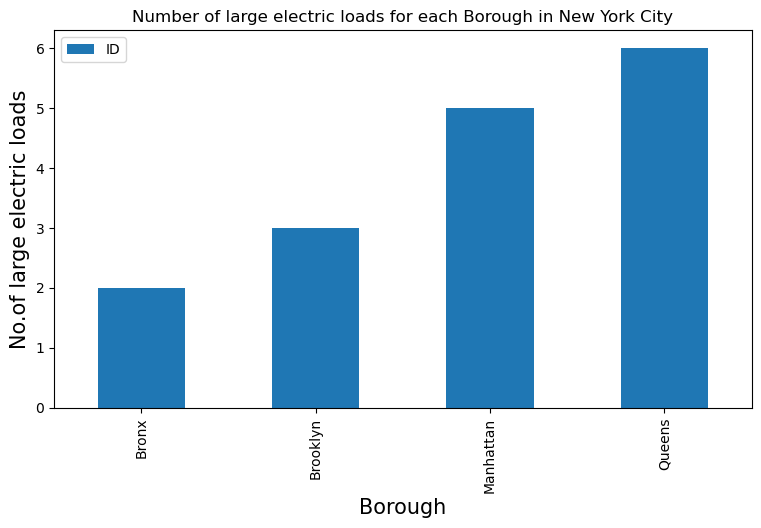

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of large electric loads for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of large electric loads', fontsize=15)
electric_loads_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
#displays the plot
plt.show()

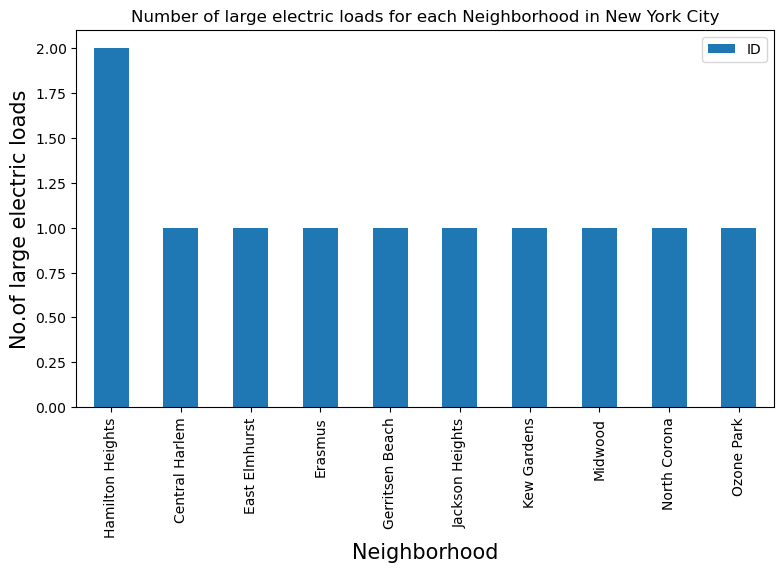

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of large electric loads for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of large electric loads', fontsize=15)
electric_loads_ny.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind='bar')
plt.legend()
plt.show()

In [15]:
electric_loads_ny[electric_loads_ny['Neighborhood']=='Baychester']

,Borough,Neighborhood,ID,Name


In [16]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
electric_loads_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in electric_loads_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these large electric loads as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(electric_loads_ny),')','processed')
    electric_loads_stats_ny = electric_loads_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
electric_loads_stats_ny.tail()

dict_keys(['venue'])
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4f39467ae4b039c3c45d8406
( 1 / 16 ) processed
dict_keys(['venue'])
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4df91a381f6e448ec2919a67
( 2 / 16 ) processed
dict_keys(['venue'])
                         ID                                   Name  Likes  \
0  4d36fd214f36a1433e313f27  P.S. 277 - The Gerritsen Beach School      5   

   Rating  Tips  
0     6.8     1  
( 3 / 16 ) processed
dict_keys(['venue'])
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e724732aeb79ea09552b493
( 4 / 16 ) processed
dict_keys(['venue'])
                         ID                       Name  Likes  Rating  Tips
0  4abc0f05f964a5202d8620e3  Harlem School of the Arts     17     8.4     3
( 5 / 16 ) processed
dict_keys(['venue'])
                         ID                           Name  Likes  Ratin

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
11,Queens,East Elmhurst,0,0,0,0,0
12,Queens,Ozone Park,4dc5c222ae608779d1444723,Pc Richards & Son,6,5.9,1
13,Queens,North Corona,0,0,0,0,0
14,Brooklyn,Erasmus,0,0,0,0,0
15,Queens,Queensbridge,4eb9ce585c5c0e067d14c79e,PS 217,5,7.1,2


In [17]:
electric_loads_stats_ny.head(10)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Port Morris,0,0,0,0,0
1,Bronx,Unionport,0,0,0,0,0
2,Brooklyn,Gerritsen Beach,4d36fd214f36a1433e313f27,P.S. 277 - The Gerritsen Beach School,5,6.8,1
3,Brooklyn,Midwood,0,0,0,0,0
4,Manhattan,Hamilton Heights,4abc0f05f964a5202d8620e3,Harlem School of the Arts,17,8.4,3
5,Manhattan,Hamilton Heights,4ccba8a2efd2ef3b1082aa8b,P.S 153 - Adam Clayton Powell,6,7,3
6,Manhattan,Central Harlem,4abc0f05f964a5202d8620e3,Harlem School of the Arts,17,8.4,3
7,Manhattan,Roosevelt Island,4b1ee6fef964a520552124e3,Lycée Français de New York,13,7.1,0
8,Manhattan,Upper West Side,4b49fa03f964a520177726e3,PS 166 The Richard Rodgers School of Arts and ...,8,7.8,3
9,Queens,Jackson Heights,4c8f729a58668cfa100bdaec,Joseph Pulitzer IS 145,9,7,6


In [18]:
electric_loads_stats_ny.shape

(16, 7)

In [19]:
electric_loads_stats_ny.to_csv('electric_loads_stats_ny.csv', index=False)

In [20]:
electric_loads_stats_ny=pd.read_csv('electric_loads_stats_ny.csv')

In [22]:
electric_loads_stats_ny.shape

(16, 7)

In [24]:
electric_loads_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       16 non-null     object 
 1   Neighborhood  16 non-null     object 
 2   ID            16 non-null     object 
 3   Name          16 non-null     object 
 4   Likes         16 non-null     int64  
 5   Rating        16 non-null     float64
 6   Tips          16 non-null     int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 1.0+ KB


In [25]:
electric_loads_stats_ny['Likes']=electric_loads_stats_ny['Likes'].astype('float64')
electric_loads_stats_ny['Tips']=electric_loads_stats_ny['Tips'].astype('float64')
electric_loads_stats_ny['Rating']=electric_loads_stats_ny['Rating'].astype('float64')
electric_loads_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       16 non-null     object 
 1   Neighborhood  16 non-null     object 
 2   ID            16 non-null     object 
 3   Name          16 non-null     object 
 4   Likes         16 non-null     float64
 5   Rating        16 non-null     float64
 6   Tips          16 non-null     float64
dtypes: float64(3), object(4)
memory usage: 1.0+ KB


In [26]:
electric_loads_stats_ny.iloc[electric_loads_stats_ny['Likes'].idxmax()]

Borough                         Manhattan
Neighborhood             Hamilton Heights
ID               4abc0f05f964a5202d8620e3
Name            Harlem School of the Arts
Likes                                  17
Rating                                8.4
Tips                                    3
Name: 4, dtype: object

In [27]:
electric_loads_stats_ny.iloc[electric_loads_stats_ny['Rating'].idxmax()]

Borough                         Manhattan
Neighborhood             Hamilton Heights
ID               4abc0f05f964a5202d8620e3
Name            Harlem School of the Arts
Likes                                  17
Rating                                8.4
Tips                                    3
Name: 4, dtype: object

In [28]:
electric_loads_stats_ny.iloc[electric_loads_stats_ny['Tips'].idxmax()]

Borough                           Queens
Neighborhood             Jackson Heights
ID              4c8f729a58668cfa100bdaec
Name              Joseph Pulitzer IS 145
Likes                                  9
Rating                                 7
Tips                                   6
Name: 9, dtype: object

In [29]:
ny_neighborhood_stats=electric_loads_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Central Harlem,8.4
14,Upper West Side,7.8
4,Hamilton Heights,7.7
11,Queensbridge,7.1
12,Roosevelt Island,7.1
5,Jackson Heights,7.0
3,Gerritsen Beach,6.8
9,Ozone Park,5.9
1,East Elmhurst,0.0
2,Erasmus,0.0


In [30]:
ny_borough_stats=electric_loads_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False)

,Borough,Average Rating
2,Manhattan,7.740000
3,Queens,3.333333
1,Brooklyn,2.266667
0,Bronx,0.000000


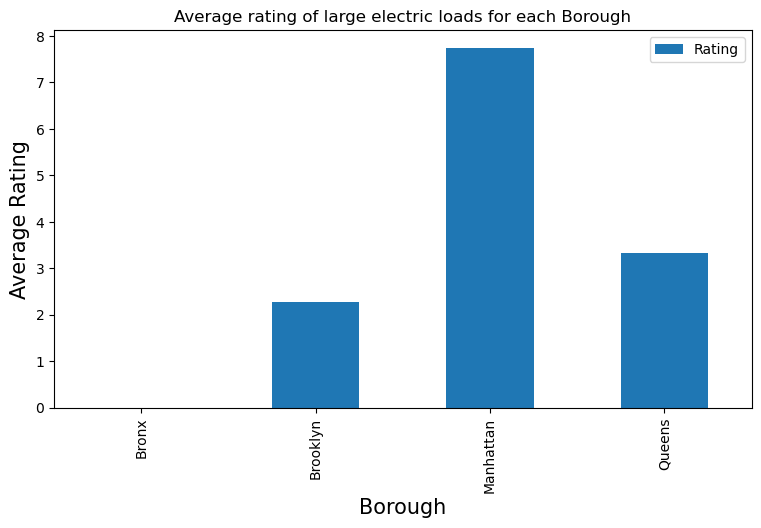

In [31]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of large electric loads for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
electric_loads_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')#legend
plt.legend()
plt.show()

In [32]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Central Harlem,8.4


In [33]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Central Harlem,40.815976,-73.943211,8.4


In [35]:
!pip install folium
import folium
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

     |████████████████████████████████| 93 kB 2.6 MB/s  eta 0:00:01


In [36]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)